<a href="https://colab.research.google.com/github/ywang1110/Modeling_Triboelectric_Performance/blob/main/Humidity___SEBS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import matplotlib.cm as cm
from IPython.display import display
from sklearn.feature_selection import f_regression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Prepare dataset

## Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_excel('drive/My Drive/1 Manuscript_AFM/Data process/3 NewData_Train - updateDiameter-Validiate.xlsx', sheet_name='mean')
df.head()

,Unnamed: 0,ChargeDensity(µC/m2) j,Thickness (um) x,solidity y,diameter (um) z,Interface (mm) u,Tem (°C),Humidity (%),Force (N),Technique
0,K-1,26.43,472.4,0.164,9.09225,1.728,26.4,25.9,35.5,Reicofil
1,K-2,28.35,568.1,0.180,9.30286,1.961,25.7,27.5,37.1,Reicofil
2,K-3,31.15,472.9,0.181,7.73240,1.501,26.9,28.5,36.1,Reicofil
3,K-4,30.28,600.2,0.179,7.77859,1.990,25.8,29.6,37.3,Reicofil
4,K-5,33.76,393.3,0.206,7.41502,1.106,26.9,28.5,36.1,Reicofil


In [4]:
df.shape

(43, 10)

## Unit conversion

In [5]:
data = pd.DataFrame()
data['ChargeDensity(C/m2)']=df['ChargeDensity(µC/m2) j']*pow(10,-6)
data['thickness(m)']=df['Thickness (um) x']*pow(10,-6)
data['solidity'] = df['solidity y']
data['diameter(m)'] = df['diameter (um) z']*pow(10,-6)
data['Interface(m)']=df['Interface  (mm) u']*pow(10, -3)
data['Technique'] = df['Technique']
data[['Tem (°C)', 'Humidity (%)', 'Force (N)']]=df[['Tem (°C)', 'Humidity (%)', 'Force (N)']]

data.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N)
0,0.000026,0.000472,0.164,0.000009,0.001728,Reicofil,26.4,25.9,35.5
1,0.000028,0.000568,0.180,0.000009,0.001961,Reicofil,25.7,27.5,37.1
2,0.000031,0.000473,0.181,0.000008,0.001501,Reicofil,26.9,28.5,36.1
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1


In [6]:
data.shape

(43, 9)

# Train test split

In [7]:
random_state=69
kf = KFold(n_splits=5, shuffle = True, random_state=random_state)
train_indexs = []
test_indexs = []
for train_index, test_index in kf.split(data):
    train_indexs.append(train_index)
    test_indexs.append(test_index)
index=pd.DataFrame(zip(train_indexs, test_indexs), columns=['train_index','test_index'])
index

,train_index,test_index
0,"[0, 2, 3, 5, 6, 7, 9, 10, 11, 12, 14, 15, 16, ...","[1, 4, 8, 13, 23, 29, 37, 39, 40]"
1,"[1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 15, 16, ...","[0, 5, 6, 10, 17, 18, 19, 27, 31]"
2,"[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 16...","[2, 14, 15, 25, 28, 30, 35, 36, 38]"
3,"[0, 1, 2, 4, 5, 6, 8, 9, 10, 11, 13, 14, 15, 1...","[3, 7, 12, 16, 21, 24, 34, 42]"
4,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15...","[9, 11, 20, 22, 26, 32, 33, 41]"


In [8]:
n_fold=2

In [9]:
train_index = index.iloc[n_fold,0]
test_index = index.iloc[n_fold,1]
train, test = data.iloc[train_index], data.iloc[test_index]
train.shape

(34, 9)

In [10]:
train.shape

(34, 9)

In [11]:
test.shape

(9, 9)

In [12]:
"""
train.to_csv('train.csv')
test.to_csv('test.csv')
"""


"\ntrain.to_csv('train.csv')\ntest.to_csv('test.csv')\n"

In [13]:
"""
train = pd.read_csv('train.csv')
test=pd.read_csv('test.csv')
"""

"\ntrain = pd.read_csv('train.csv')\ntest=pd.read_csv('test.csv')\n"

In [14]:
train.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N)
0,0.000026,0.000472,0.164,0.000009,0.001728,Reicofil,26.4,25.9,35.5
1,0.000028,0.000568,0.180,0.000009,0.001961,Reicofil,25.7,27.5,37.1
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1
5,0.000035,0.000521,0.213,0.000007,0.001530,Reicofil,26.9,25.6,38.1


In [15]:
# Train the model
x=train['thickness(m)'].to_numpy()
y=train['solidity'].to_numpy()
z=train['diameter(m)'].to_numpy()
u=train['Interface(m)'].to_numpy()
h=train['Humidity (%)'].to_numpy()
j=train['ChargeDensity(C/m2)'].to_numpy()
def func(X,a, w, c, m, n, p):
  x,y,z,u,h = X
  return (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

# lm
popt_lm,pcov = curve_fit(func,(x,y,z,u,h),j, method='lm', maxfev = 50000)
y_model_lm = func((x,y,z,u, h),popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4],popt_lm[5]) 
MSE_lm = mean_squared_error(j, y_model_lm)
MAE_lm = mean_absolute_error(j, y_model_lm)
lm_result="lm Method | MSE = {:.2E}| MAE = {:.2E}| a = {:.2E}, w = {:.2E}, c = {:.2E},m = {:.2E}, n = {:.2E}, p = {:.2E}".format(MSE_lm,MAE_lm,popt_lm[0],popt_lm[1],popt_lm[2],popt_lm[3],popt_lm[4],popt_lm[5])
lm_result  

'lm Method | MSE = 1.96E-12| MAE = 1.13E-06| a = 5.87E-06, w = 6.53E-08, c = 2.31E-01,m = 1.28E+00, n = 1.44E+00, p = 1.47E+00'

In [16]:
# initial guesses for a,b,c,m,n,p:
p0 = 1E-6 , 0 ,1. , 1. , 1., 1.

In [17]:
  # trf & dogbox
       #    a          w           c        m          n       p
  bound=((  0,         0,          0,       0,         0 ,     0 ), 
       (np.inf,    np.inf,    np.inf,     np.inf,    np.inf, np.inf))
  
  ## trf
  popt_trf,pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='trf', maxfev=50000)

  y_model_trf = func((x,y,z,u,h),popt_trf[0],popt_trf[1],popt_trf[2], popt_trf[3],popt_trf[4],popt_trf[5]) 
  MSE_trf = np.sum((j - y_model_trf)**2)/train.shape[0]
  MAE_trf = np.sum(abs(j - y_model_trf))/train.shape[0]

  ## dogbox
  popt_dog, pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='dogbox', maxfev=50000)
  y_model_dog = func((x,y,z,u,h),popt_dog[0],popt_dog[1],popt_dog[2],popt_dog[3],popt_dog[4],popt_dog[5]) 
  MSE_dog = np.sum((j - y_model_dog)**2)/train.shape[0]
  MAE_dog = np.sum(abs(j - y_model_dog))/train.shape[0]

  if MSE_trf < MSE_dog:
    a,w,c,m,n,p = popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5]
    print('trf Method is the best method')
  else:
    a,w,c,m,n,p = popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5]
    print("dogbox Method is the best method")
  trf_result="trf Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_trf,MAE_trf,popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5])
  dog_result="dog Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_dog,MAE_dog,popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5])
  print(trf_result)
  print(dog_result)

trf Method is the best method
trf Method | MSE = 1.96E-12| MAE = 1.13E-06| a = 5.874322373286812e-06, w = 6.534235949232691e-08, c = 0.23141858659366696,m = 1.2810318155346905, n = 1.4369036386191405, p = 1.4686712848195835
dog Method | MSE = 3.11E-11| MAE = 4.51E-06| a = 3.0150341873134238e-06, w = 0.0, c = 1.057881457452267,m = 1.0000074483021628, n = 1.0000090607620764, p = 1.0000097592583057


In [18]:
  # Validate (when trf is best)

  data_val = pd.concat([train, test])
  data_val.head()
  x=data_val['thickness(m)'].to_numpy()
  y=data_val['solidity'].to_numpy()
  z=data_val['diameter(m)'].to_numpy()
  u=data_val['Interface(m)'].to_numpy()
  h=data_val['Humidity (%)'].to_numpy()
  j=data_val['ChargeDensity(C/m2)'].to_numpy()

  


  data_val['Predicted(C/m2)'] = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

  data_val['ratio(%)'] = (data_val['Predicted(C/m2)'] -data_val['ChargeDensity(C/m2)'])/data_val['ChargeDensity(C/m2)']*100
  data_val['ChargeDensity(uC/m2)'] = data_val['ChargeDensity(C/m2)']*pow(10,6)
  data_val['Predicted(uC/m2)'] = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)*pow(10,6)
  data_val['ratio_2(%)'] = (data_val['Predicted(uC/m2)']-data_val['ChargeDensity(uC/m2)'])/data_val['ChargeDensity(uC/m2)']*100
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
  mape = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'], data_val['Predicted(C/m2)'])
  mape_train = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][0:train.shape[0]], data_val['Predicted(C/m2)'][0:train.shape[0]])
  mape_test = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][train.shape[0]:data_val.shape[0]], data_val['Predicted(C/m2)'][train.shape[0]:data_val.shape[0]])
  
  print('MAPE= {:.2f}'.format(mape))
  print('Train_MAPE = {:.2f}'.format(mape_train))
  print('test_MAPE = {:.2f}'.format(mape_test))

MAPE= 4.46
Train_MAPE = 4.21
test_MAPE = 5.38


In [19]:
data_val.head()

,ChargeDensity(C/m2),thickness(m),solidity,diameter(m),Interface(m),Technique,Tem (°C),Humidity (%),Force (N),Predicted(C/m2),ratio(%),ChargeDensity(uC/m2),Predicted(uC/m2),ratio_2(%)
0,0.000026,0.000472,0.164,0.000009,0.001728,Reicofil,26.4,25.9,35.5,0.000026,-0.101657,26.43,26.403132,-0.101657
1,0.000028,0.000568,0.180,0.000009,0.001961,Reicofil,25.7,27.5,37.1,0.000028,-0.208301,28.35,28.290947,-0.208301
3,0.000030,0.000600,0.179,0.000008,0.001990,Reicofil,25.8,29.6,37.3,0.000028,-7.761488,30.28,27.929822,-7.761488
4,0.000034,0.000393,0.206,0.000007,0.001106,Reicofil,26.9,28.5,36.1,0.000031,-9.351349,33.76,30.602985,-9.351349
5,0.000035,0.000521,0.213,0.000007,0.001530,Reicofil,26.9,25.6,38.1,0.000033,-5.317701,34.67,32.826353,-5.317701


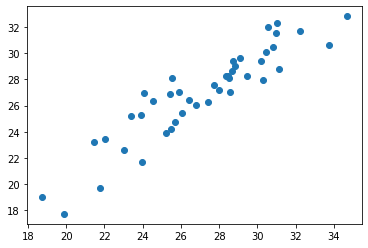

In [20]:
import matplotlib.pyplot as plt
plt.scatter(data_val['ChargeDensity(uC/m2)'], data_val['Predicted(uC/m2)'])
plt.show()

# Validation at different random seeds

In [21]:
def get_index(random_state, data):
  kf = KFold(n_splits=5, shuffle = True, random_state=random_state)
  train_indexs = []
  test_indexs = []
  for train_index, test_index in kf.split(data):
      train_indexs.append(train_index)
      test_indexs.append(test_index)
  index=pd.DataFrame(zip(train_indexs, test_indexs), columns=['train_index','test_index'])
  return index

In [22]:
def get_scores(n_fold, index, data):
  train_index = index.iloc[n_fold,0]
  test_index = index.iloc[n_fold,1]
  train, test = data.iloc[train_index], data.iloc[test_index]
  train_shape=train.shape
  test_shape=test.shape

  def func(X,a, w, c, m, n, p):
    x,y,z,u,h = X
    return (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

  x=train['thickness(m)'].to_numpy()
  y=train['solidity'].to_numpy()
  z=train['diameter(m)'].to_numpy()
  u=train['Interface(m)'].to_numpy()
  h=train['Humidity (%)'].to_numpy()
  j=train['ChargeDensity(C/m2)'].to_numpy()


  # initial guesses for a,b,c,m,n,p:
  p0 = 1E-6 , 1E-10 ,1. , 1. , 1., 1.

   # trf & dogbox
       #    a          w           c        m          n       p
  bound=((  0,         0,          0,       0,         0 ,     0 ), 
       (np.inf,    np.inf,    np.inf,     np.inf,    np.inf, np.inf))
  
  ## trf
  popt_trf,pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='trf', maxfev=500000)

  y_model_trf = func((x,y,z,u,h),popt_trf[0],popt_trf[1],popt_trf[2], popt_trf[3],popt_trf[4],popt_trf[5]) 
  MSE_trf = np.sum((j - y_model_trf)**2)/train.shape[0]
  MAE_trf = np.sum(abs(j - y_model_trf))/train.shape[0]

  ## dogbox
  popt_dog, pcov = curve_fit(func,(x,y,z,u,h),j, p0, bounds = bound, method='dogbox', maxfev=500000)
  y_model_dog = func((x,y,z,u,h),popt_dog[0],popt_dog[1],popt_dog[2],popt_dog[3],popt_dog[4],popt_dog[5]) 
  MSE_dog = np.sum((j - y_model_dog)**2)/train.shape[0]
  MAE_dog = np.sum(abs(j - y_model_dog))/train.shape[0]

  if MSE_trf < MSE_dog:
    a,w,c,m,n,p = popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5]
    print('trf Method is the best method')
  else:
    a,w,c,m,n,p = popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5]
    print("dogbox Method is the best method")
  trf_result="trf Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_trf,MAE_trf,popt_trf[0],popt_trf[1],popt_trf[2],popt_trf[3],popt_trf[4], popt_trf[5])
  dog_result="dog Method | MSE = {:.2E}| MAE = {:.2E}| a = {}, w = {}, c = {},m = {}, n = {}, p = {}".format(MSE_dog,MAE_dog,popt_dog[0], popt_dog[1], popt_dog[2], popt_dog[3], popt_dog[4], popt_dog[5])
  # print(trf_result)
  # print(dog_result)
  
  # Validate 
  
  data_val = pd.concat([train, test])
  x=data_val['thickness(m)'].to_numpy()
  y=data_val['solidity'].to_numpy()
  z=data_val['diameter(m)'].to_numpy()
  u=data_val['Interface(m)'].to_numpy()
  h=data_val['Humidity (%)'].to_numpy()
  j=data_val['ChargeDensity(C/m2)'].to_numpy()


  data_val['Predicted(C/m2)'] = (a-w*h)*(2*x*y/z-c*y**m*x**n/z**p)*0.01/(0.01+u)

  
  def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
  
  mape_trf = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'], data_val['Predicted(C/m2)'])
  mape_trf_train = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][0:train.shape[0]], data_val['Predicted(C/m2)'][0:train.shape[0]])
  mape_trf_test = mean_absolute_percentage_error(data_val['ChargeDensity(C/m2)'][train.shape[0]:data_val.shape[0]], data_val['Predicted(C/m2)'][train.shape[0]:data_val.shape[0]])

  return n_fold, train_shape, test_shape, mape_trf, mape_trf_train, mape_trf_test

In [23]:
max_random_sate = 100

In [ ]:
random_states = []
n_folds = []
train_shapes = []
test_shapes = []

MAPEs = []
train_MAPEs = []
test_MAPEs = []


for random_state in range(max_random_sate):
  index = get_index(random_state, data)
  for n_fold in range(5):
    random_states.append(random_state)
    n_fold, train_shape, test_shape, MAPE, train_MAPE, test_MAPE = get_scores(n_fold, index, data)
    n_folds.append(n_fold)
    train_shapes.append(train_shape)
    test_shapes.append(test_shape)
    
    MAPEs.append(MAPE)
    train_MAPEs.append(train_MAPE)
    test_MAPEs.append(test_MAPE)


trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method is the best method
trf Method

In [ ]:
summary = pd.DataFrame()
summary['random_state']=random_states
summary['n_fold']=n_folds
summary['train_shape'] = train_shapes
summary['test_shape'] = test_shapes

summary['MAPE'] = MAPEs
summary['train_MAPE'] = train_MAPEs
summary['test_MAPE'] = test_MAPEs

summary

In [ ]:
summary.describe()

In [ ]:
summary.to_csv('100RandomState_SEBS.csv')